# Calculating NDVI

In [2]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
from pyspark.sql import *
from pyspark.sql.functions import udf
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()
    
resource_dir = Path('./samples').resolve()

In [3]:
redBand = spark.read.geotiff(resource_dir.joinpath('L8-B4-Elkton-VA.tiff').as_uri()).withColumnRenamed('tile', 'red_band')
nirBand = spark.read.geotiff(resource_dir.joinpath('L8-B5-Elkton-VA.tiff').as_uri()).withColumnRenamed('tile', 'nir_band')

In [4]:
redBand.select(tileStats('red_band')).show(1, False)
nirBand.select(tileStats('nir_band')).show(1, False)

+----------------------------------------------------------+
|tileStats(red_band)                                       |
+----------------------------------------------------------+
|[28561,6396.0,27835.0,7444.425440285682,1293316.416913802]|
+----------------------------------------------------------+

+--------------------------------------------------------------+
|tileStats(nir_band)                                           |
+--------------------------------------------------------------+
|[28561,5623.0,39368.0,20256.408319036327,1.0355944001196865E7]|
+--------------------------------------------------------------+



In [6]:
# shouldn't those values be switched? Why is the mean of the normalized difference above 1?
rf = redBand.asRF().spatialJoin(nirBand.asRF()) \
    .withColumn("ndvi", normalizedDifference('red_band', 'nir_band')).asRF()
rf.select(tileStats('ndvi')).show(1, False)

+-------------------------------------------------------+
|tileStats(ndvi)                                        |
+-------------------------------------------------------+
|[28561,0.0,32.0,1.3563600714260704,0.31213778204633796]|
+-------------------------------------------------------+



In [20]:
pixels = np.reshape(np.clip(np.asarray(rf.select(tileToIntArray('ndvi')).first(), dtype = np.uint8), 0, 4), (-1, 169))

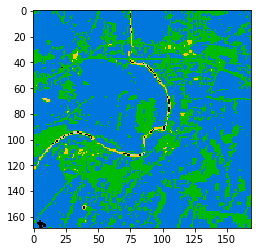

In [21]:
imgplot = plt.imshow(pixels)
imgplot.set_cmap('nipy_spectral')

In [ ]:
spark.stop()